# Analyze features - EDA. Flexible.

* Analyze features - EDA. Flexible.
* Compute ROC-AUC single features, or z = (mean_1 - mean_2) / std or ..
* Plot KDE or boxplots or swarm plots
* Compare with random features
* Perform stat tests (mann-whitney/t-test with FWE correction)

In [25]:
import numpy as np
import pandas as pd
from scipy.signal import welch
from utils import get_extracts, plot_rawsignal

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)
sns.set_style(style='white') 

In [2]:
data_pre = pd.read_csv('preproc_data/preprocessed.csv')

In [3]:
fns = data_pre['fn']
targets = data_pre['target']
sfreqs = data_pre['sfreq']

records, targets, subjects = get_extracts(fns, targets, sfreqs)

Let's begin with a basic exploration of the raw data, in the next two plots we'll see raw signals of two random subjects each corresponding to a different group

In [6]:
targets[20], targets[150]

('trauma', 'healthy')

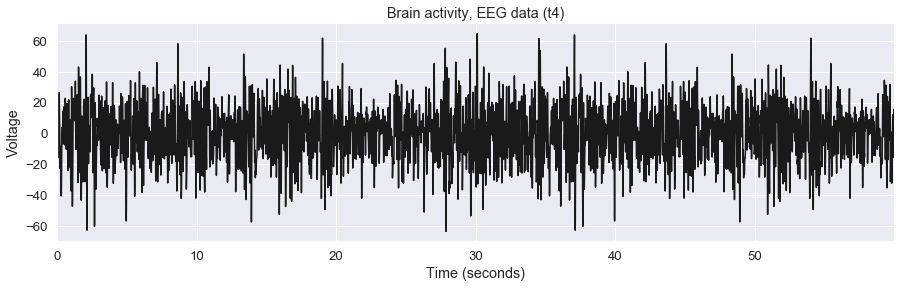

In [5]:
# subject 20 correspond to trauma group
subject = 20
channel = 't4'

signal = records[subject][channel]

# Define sampling frequency and time vector
sf = 125.
time = np.arange(records[subject].shape[0]) / sf

plot_rawsignal(time, signal, channel)

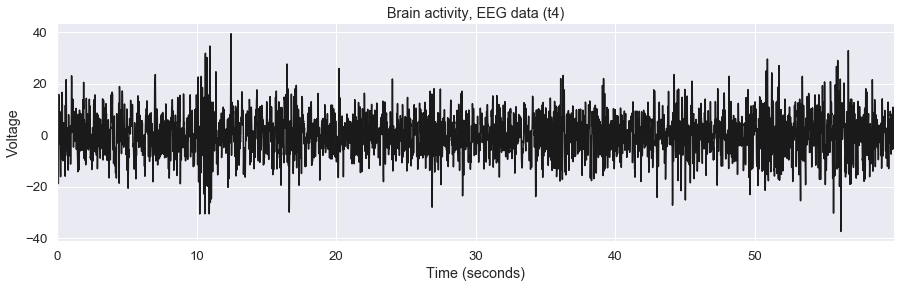

In [7]:
# subject 150 correspond to a healthy group
subject = 150
channel = 't4'

signal = records[subject][channel]

# Define sampling frequency and time vector
sf = 125.
time = np.arange(records[subject].shape[0]) / sf

plot_rawsignal(time, signal, channel)

From these plots there is almost nothing we can infer visually for our task, 
so we need another way to visualize the information. 

Let's see more meaningful pictures for the same subjects(20, 150) and the same channels `t4`, specifically we will see the psd (short for power spectral density) values, but more on this later

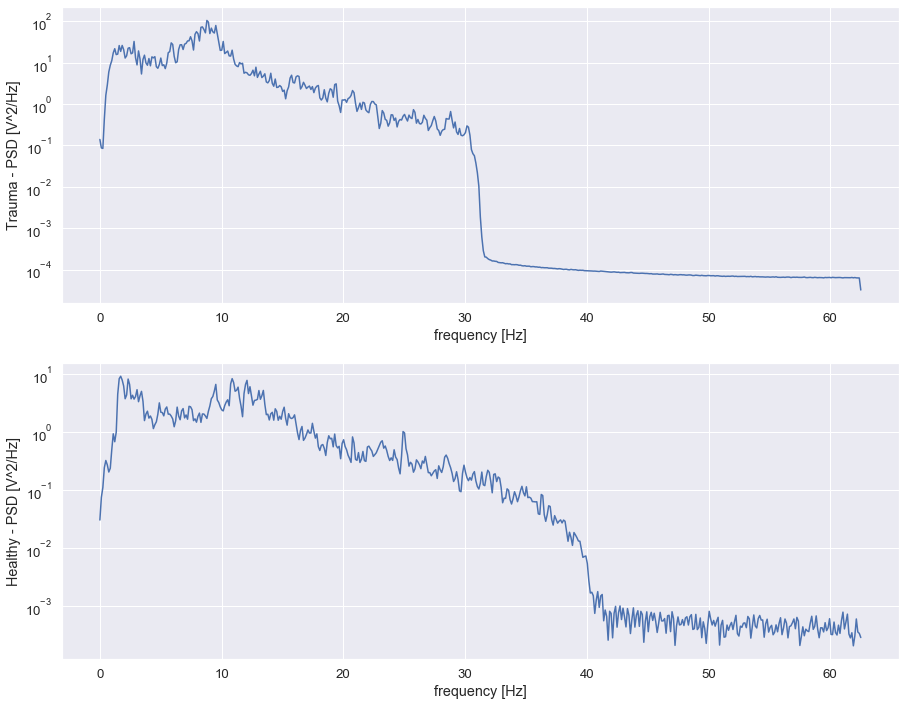

In [14]:
freqs, psd = welch(records[20]['t4'], fs=125, nperseg=1024)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[15,12])
axs[0].semilogy(freqs, psd)
axs[0].set_xlabel('frequency [Hz]')
axs[0].set_ylabel('Trauma - PSD [V^2/Hz]')

freqs, psd = welch(records[150]['t4'], fs=125, nperseg=1024)
axs[1].semilogy(freqs, psd)
axs[1].set_xlabel('frequency [Hz]')
axs[1].set_ylabel('Healthy - PSD [V^2/Hz]')

plt.show()

There seems to be a difference of PSD values for the trauma and healthy group. In the first case there is huge drop on the psd value for frequencies higher than 30 Hz. In the latter, however, the drop of psd is smooth and happens for frequencies above 40 Hz.

This difference would suggest the filtering of the signal (a rough estimate would drop frequencies greather than > 30Hz and < 1Hz)

Now let's see in more detail how the PSD can be used, for that we'll compute the
__*Average Band Power*__

Basically means that we will try to find a number representing the power contribution of a particular frequency band to the overall power of the signal.

For instance, we can analyse the delta band as mentioned here
(https://www.frontiersin.org/articles/10.3389/fnhum.2015.00011/full)
> mTBI injury is often associated with a decrease in alpha power and an __increase in delta__, beta, and theta bands.


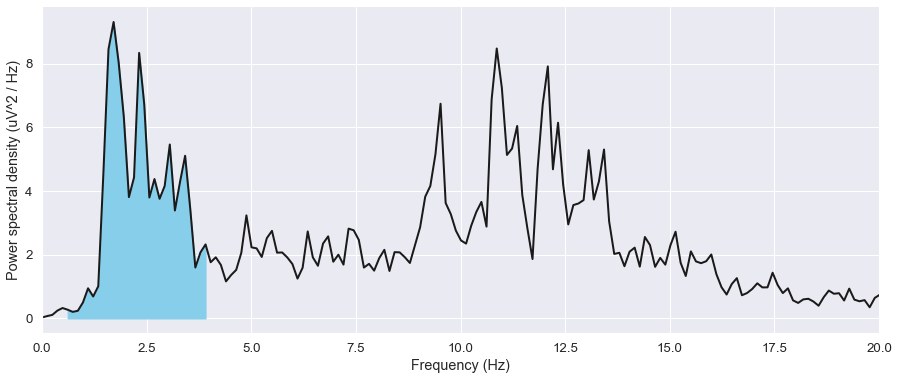

In [16]:
# Define delta lower and upper limits
low, high = 0.5, 4

# Find intersecting values in frequency vector
idx_delta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=[15, 6])
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 20])
sns.despine()

Let's compute the absolute and realtive power of this band (blue are in the plot above)

In [17]:
from scipy.integrate import simps

# Frequency resolution
freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25

# Compute the absolute power by approximating the area under the curve
delta_power = simps(psd[idx_delta], dx=freq_res)
print('Absolute delta power: %.3f uV^2' % delta_power)

# Relative delta power (expressed as a percentage of total power)
total_power = simps(psd, dx=freq_res)
delta_rel_power = delta_power / total_power
print('Relative delta power: %.3f' % delta_rel_power)

Absolute delta power: 12.983 uV^2
Relative delta power: 0.231


The realtive delta power means that 23.1% of the total power is contribuited by this band

After this initial exploration we have decided to compute whole sets of features such as coherence, envelope, band power ratios, averages in certain regions of the brain.

For a complete set of feature generation refer to `FeaturesEngineering.ipynb` file

# 1) Computing ROC_AUC, Z-scores and Kurtosis

In [36]:
from sklearn.metrics import roc_auc_score
from scipy.stats import zscore
import random
from scipy.stats import kurtosis, skew

def feat_rocauc(df, features=None, apply_sort=True):
    rows = []
    if features is None:
        features = [col for col in df.columns if col not in ['target', 'fn']]
    for feat in features:
        roc_auc = roc_auc_score(df['target'], df[feat])
        roc_auc = max(roc_auc, 1 - roc_auc)
        
        d = {
            'feature': feat,
            'roc_auc': roc_auc,
            'mean_difference': df[feat][df['target'] == 1].mean() - df[feat][df['target'] == 0].mean()
        }
        rows.append(d)
    res = pd.DataFrame(rows)
    if apply_sort:
        res = res.sort_values('roc_auc', ascending=False)
    return res

def calc_zscore(df, outpath, features=None):
    if features is None:
        features = [col for col in df.columns if col not in ['target', 'fn']]
    
    dzs=[]
    for feat in features:
        dz = zscore(df[feat])
        dzs.append(dz)
    
    dz = pd.DataFrame(dzs).transpose()
    dz.columns = features
    dz['target'] = df['target']
    dz.to_csv('{}/zscores.csv'.format(outpath), index=False)
    return dz


def calc_kurtosis(df, features=None):
    if features is None:
        features = [col for col in df.columns if col not in ['target', 'fn']]
    
    dks=[]
    dks2 = []
    for feat in features:
        dk = kurtosis(df[df['target']=='trauma'][feat])
        dk2 = kurtosis(df[df['target']=='healthy'][feat])
        dks.append(dk)
        dks2.append(dk2)
        
    tag = features[0][0:3]
    dk = pd.DataFrame({'kurt_trauma':dks, 'kurt_healthy':dks2})
    dk.to_csv(f'ml_data/{tag}_kurtosis.csv', index=False)
    return dk

### Detailed feature analysis

Here we will analyse features that were generated in the previous step. It will be done as follows:
* Individual feature
* Set of features

#### Individual feature

We will analyse the set of features with several methods such as KDE, boxplots, swarm

**Coherence Analysis**

* KDE: 
We will see the probability density estimation (KDE) of a random feature for __trauma__ and __healthy__ groups for a random subject.

In [23]:
coh = pd.read_csv('ml_data/coh.csv')

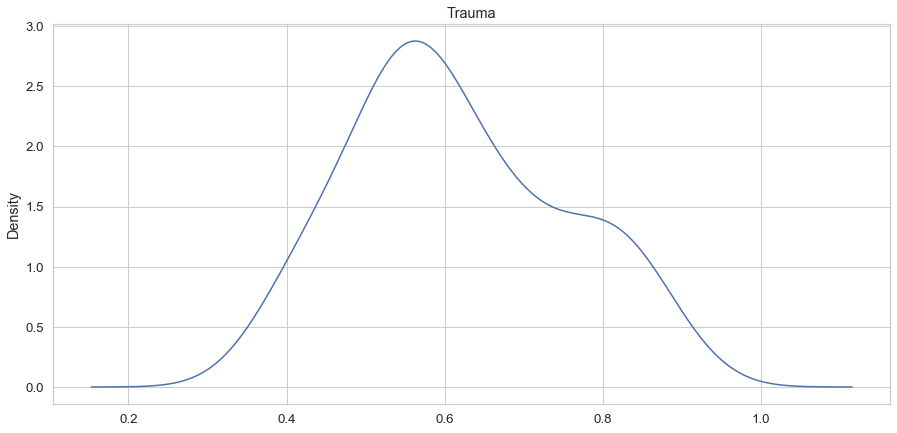

In [28]:
sns.set_style("whitegrid")
ax = coh[coh['target']=='trauma']['coh_nofilt_fp1_t3'].plot.kde(figsize=[15,7], title='Trauma')

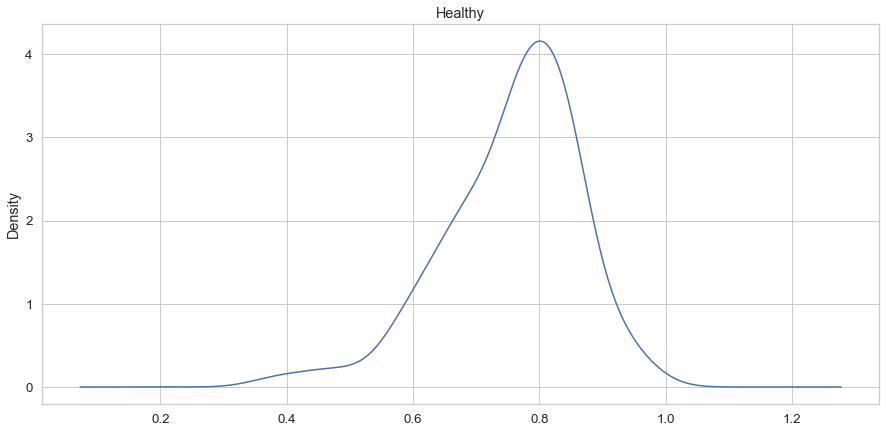

In [29]:
ax = coh[coh['target']=='healthy']['coh_nofilt_fp1_t3'].plot.kde(figsize=[15,7], title='Healthy')

From the density plots we can say that healthy subjects approximate to a gaussian distribution, on the other hand trauma group also looks similar to a gaussian with more than one mode which could come from a mixture of gaussian.

* Box plot

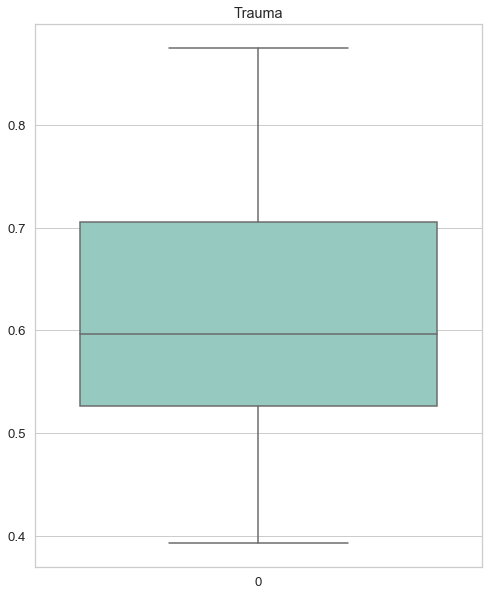

In [30]:
# Specific feature
fig = plt.figure(figsize=[8,10])
ax = sns.boxplot(data=coh[coh['target']=='trauma']['coh_nofilt_fp1_t3'], palette="Set3", orient='v')
plt.title('Trauma')
plt.show()

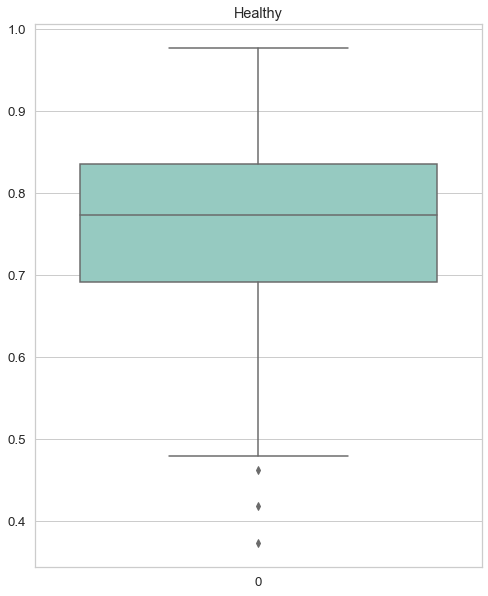

In [32]:
# Specific feature
fig = plt.figure(figsize=[8, 10])
ax = sns.boxplot(data=coh[coh['target']=='healthy']['coh_nofilt_fp1_t3'].values, palette="Set3", orient='v')
plt.title('Healthy')
plt.show()

We can say that median of healthy subjects is higher compared with trauma subject

* Swarm

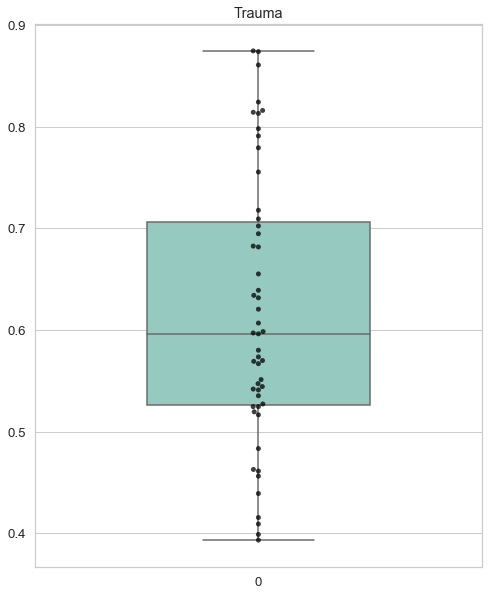

In [34]:
# Specific feature
fig = plt.figure(figsize=[8,10])
bplot = sns.boxplot(data=coh[coh['target']=='trauma']['coh_nofilt_fp1_t3'], palette="Set3", width=0.5, orient='v')
plt.title('Trauma')
 
# add swarmplot
bplot=sns.swarmplot(data=coh[coh['target']=='trauma']['coh_nofilt_fp1_t3'], 
              color='black',
              alpha=0.75)

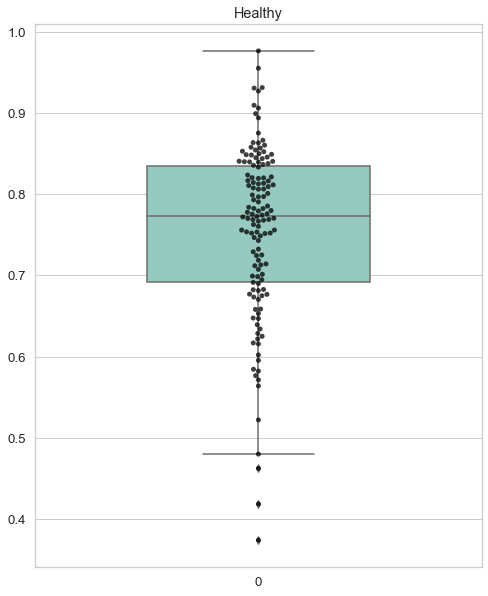

In [35]:
# Specific feature
fig = plt.figure(figsize=[8,10])
bplot = sns.boxplot(data=coh[coh['target']=='healthy']['coh_nofilt_fp1_t3'].values, palette="Set3", width=0.5, orient='v')
plt.title('Healthy')
 
# add swarmplot
bplot=sns.swarmplot(data=coh[coh['target']=='healthy']['coh_nofilt_fp1_t3'].values, 
              color='black',
              alpha=0.75)

#### Set of features

Now let's make general visualizations to compare for a set of features and across groups

In [41]:
def plot_kde(df, features=[], rand=False, nfeats=5, groups=False):
    
    if len(features)>0:
        rand=False
        
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[25,10])

        # 1st group
        for f in range(len(features)):
            sns.kdeplot(df[df['target']=='trauma'][features[f]], ax=axs[0])
        axs[0].set_title(label='Trauma', fontweight="bold", size=20)

        # 2nd group
        for f in range(len(features)):
            sns.kdeplot(df[df['target']=='healthy'][features[f]], ax=axs[1])
        axs[1].set_title(label='Healthy', fontweight="bold", size=20)
        
        # Individual comparison
        if len(features)>1:
            fig, axs = plt.subplots(nrows=2, ncols=len(features), figsize=[26,10])
            plt.suptitle('Individual comparison of features', size=20)
            # first group
            for f in range(len(features)):
                sns.kdeplot(df[df['target']=='trauma'][features[f]], ax=axs[0, f], color='r', shade=True)

            # second group
            for f in range(len(features)):
                sns.kdeplot(df[df['target']=='healthy'][features[f]], ax=axs[1, f], shade=True)
            for i, ax in enumerate(axs.flat):
                if i==0:
                    ax.set(ylabel='trauma')
                if i==len(features):
                    ax.set(ylabel='healthy')

                if i >= len(features):
                    ax.set(xlabel=features[i-len(features)])
            
    if rand:
        feats = df[df.columns[~df.columns.isin(['fn','target'])]].columns.tolist()
        features = random.choices(feats, k=nfeats)
        
        
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[25,10])
        
        # Group
        # 1st group
        for f in range(len(features)):
            sns.kdeplot(df[df['target']=='trauma'][features[f]], ax=axs[0])
        axs[0].set_title(label='Trauma', fontweight="bold", size=20)

        # 2nd group
        for f in range(len(features)):
            sns.kdeplot(df[df['target']=='healthy'][features[f]], ax=axs[1])
        axs[1].set_title(label='Healthy', fontweight="bold", size=20)
        
        
        
        # Individual comparison
        fig, axs = plt.subplots(nrows=2, ncols=nfeats, figsize=[26,10])
        plt.suptitle('Individual comparison of features', size=20)

        # first group
        for f in range(len(features)):
            sns.kdeplot(df[df['target']=='trauma'][features[f]], ax=axs[0, f], color='r', shade=True)

        # second group
        for f in range(len(features)):
            sns.kdeplot(df[df['target']=='healthy'][features[f]], ax=axs[1, f], shade=True)
        for i, ax in enumerate(axs.flat):
            if i==0:
                ax.set_ylabel(ylabel='trauma', size=18)
            if i==nfeats:
                ax.set_ylabel(ylabel='healthy', size=18)
            
            if i >= nfeats:
                ax.set_xlabel(xlabel=features[i-nfeats], size=13)

**Coherence Analysis**

* KDE

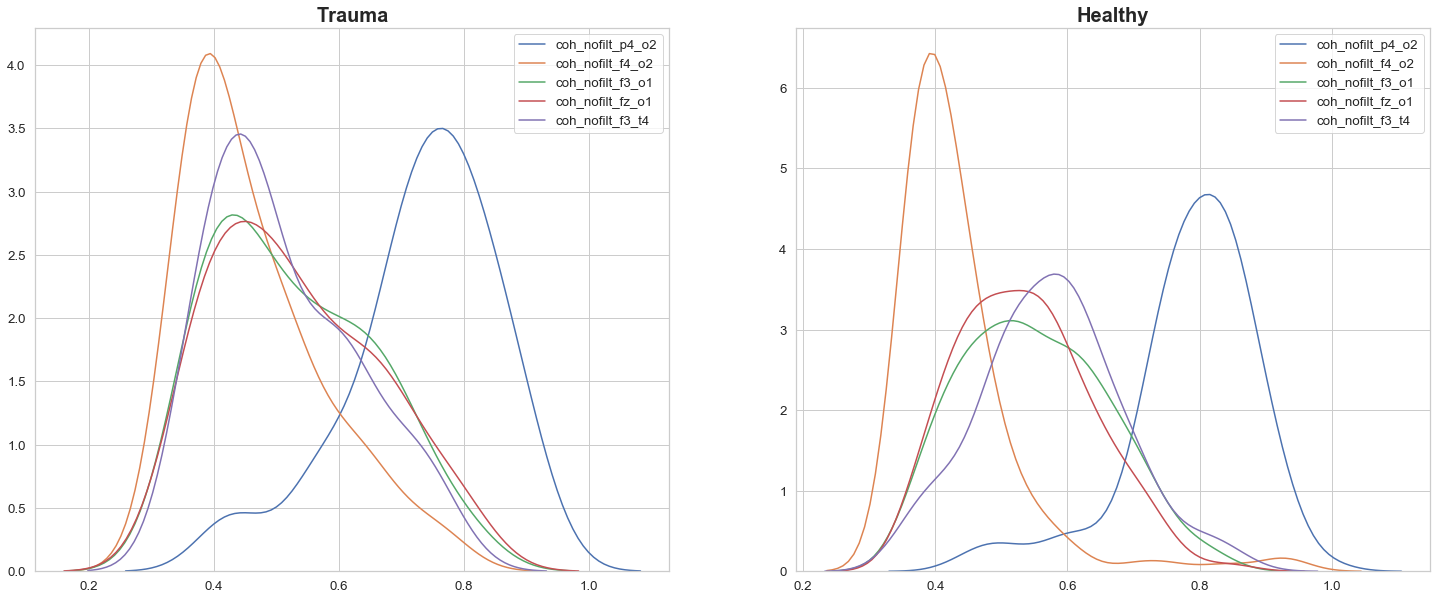

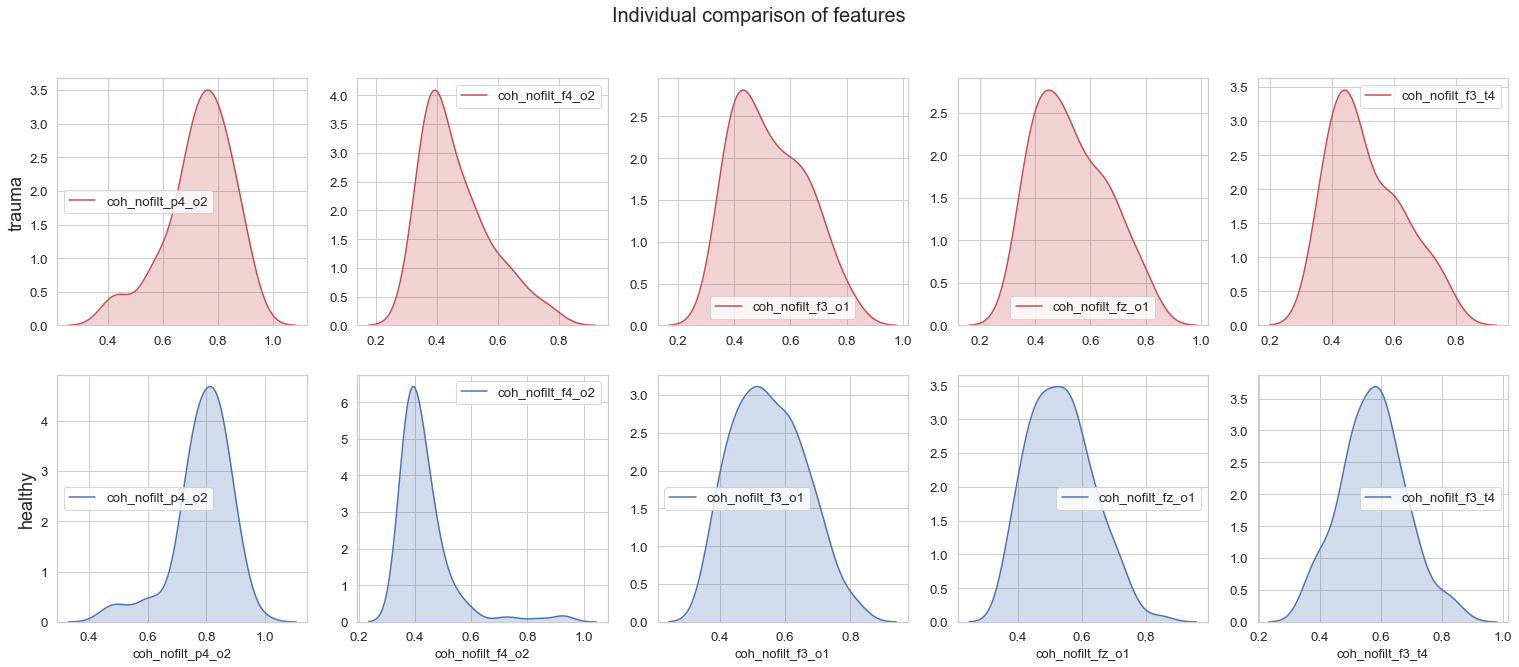

In [42]:
plot_kde(coh, rand=True, nfeats=5)

* Box plot

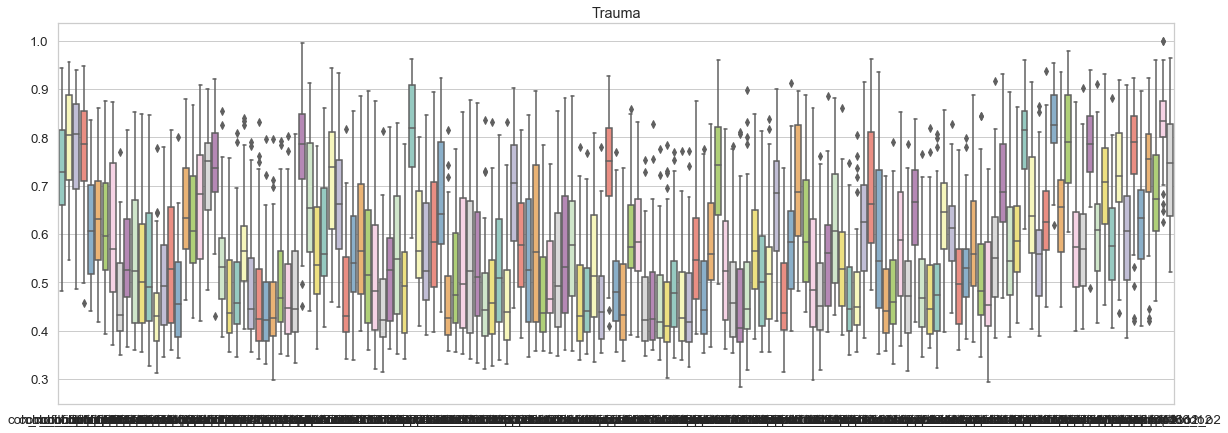

In [55]:
# Whole set of features
fig = plt.figure(figsize=[20,7])
ax = sns.boxplot(data=coh[coh['target']=='trauma'], palette="Set3", orient='v')
plt.title('Trauma')
plt.show()

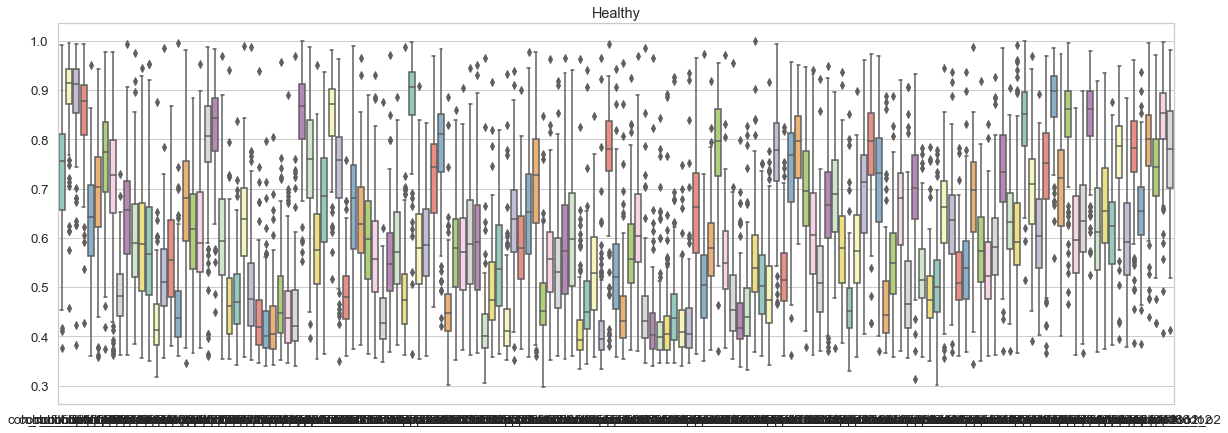

In [56]:
fig = plt.figure(figsize=[20,7])
ax = sns.boxplot(data=coh[coh['target']=='healthy'], palette="Set3", orient='v')
plt.title('Healthy')
plt.show()

From the plots above we can see that most of the coherence features for traumatic injured subjects have lower values than the healthy group. 

This might be our _**first strong biomarker**_ for our task, since coherence can tell us how connected (coherent) different brain regions are<sup>1</sup>. This makes sense because if the brain is injured then connections around that area are lost or weakened, thus coherence would be lower.

[1] Bowyer, S.M. Coherence a measure of the brain networks: past and present. Neuropsychiatr Electrophysiol 2, 1 (2016). https://doi.org/10.1186/s40810-015-0015-7

**Z Score**

* KDE

In [48]:
#zcoh = calc_zscore(coh[coh.columns[~coh.columns.isin(['fn','target'])]], 'ml_data')
zcoh = calc_zscore(coh, 'ml_data')

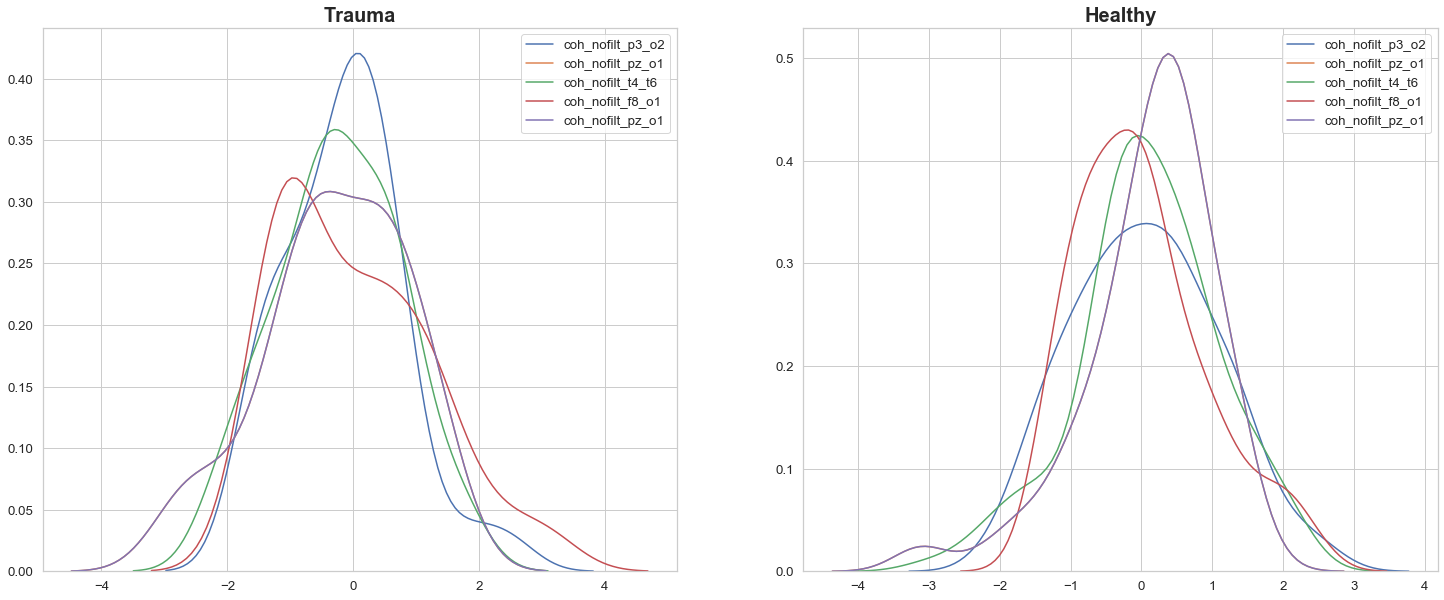

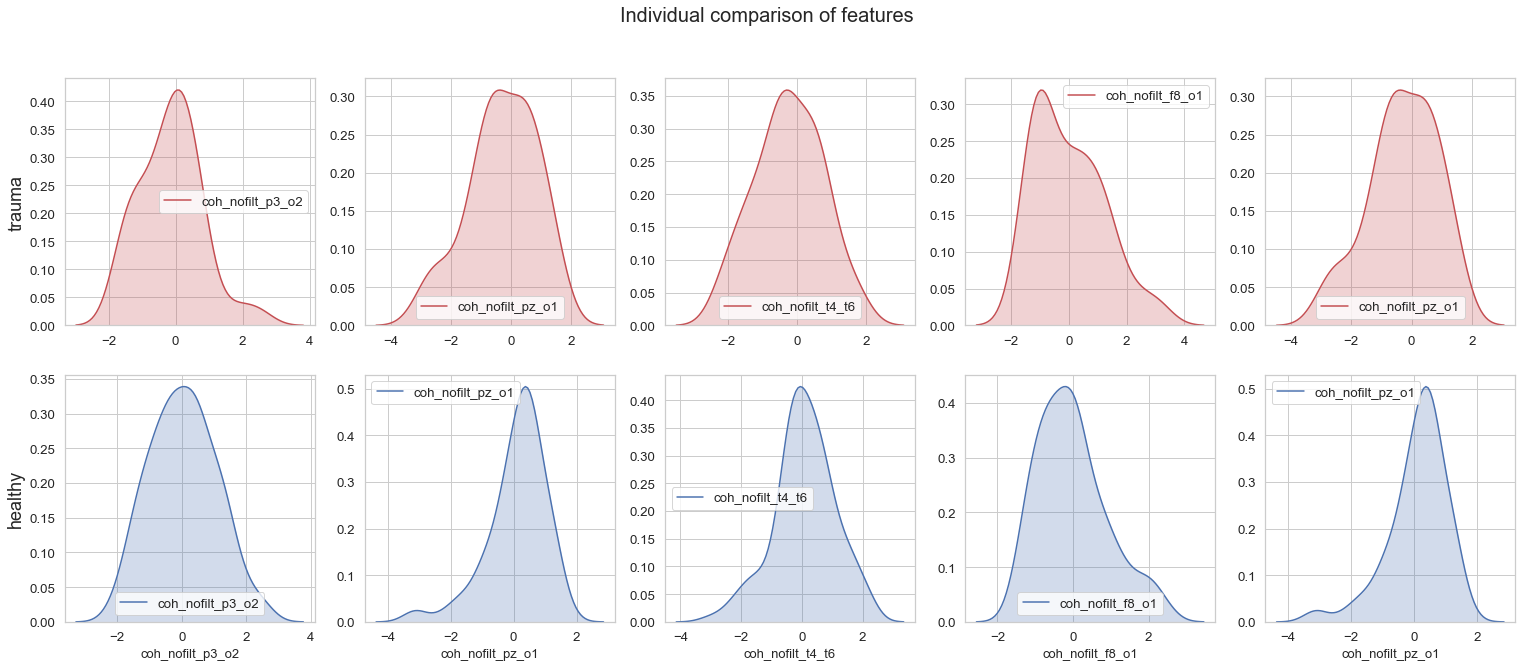

In [49]:
plot_kde(zcoh, rand=True, nfeats=5)

**Kurtosis**

* Distribution

For the coherence set of features

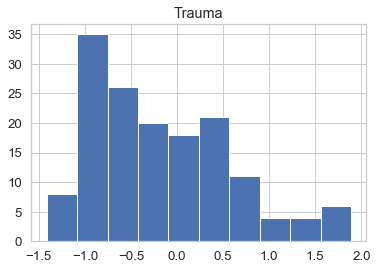

In [58]:
kcoh = calc_kurtosis(coh)

plt.hist(kcoh['kurt_trauma'])
plt.title('Trauma')
plt.show()

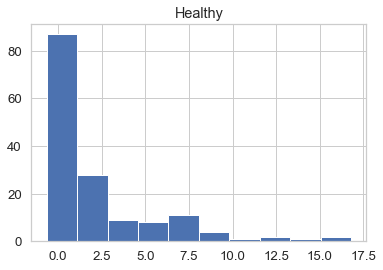

In [59]:
plt.hist(kcoh['kurt_healthy'])
plt.title('Healthy')
plt.show()

* Kurtosis measure for coherence of **alpha band**

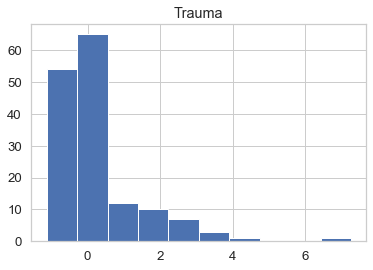

In [62]:
coh_alpha = pd.read_csv('ml_data/coh_alpha.csv')

kcoh = calc_kurtosis(coh_alpha)

plt.hist(kcoh['kurt_trauma'])
plt.title('Trauma')
plt.show()

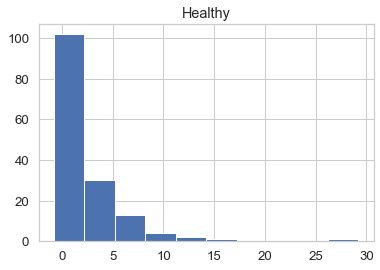

In [63]:
kcoh = calc_kurtosis(coh_alpha)

plt.hist(kcoh['kurt_healthy'])
plt.title('Healthy')
plt.show()

* Kurtosis measure for coherence of **beta band**

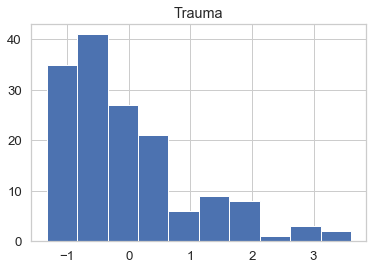

In [65]:
coh_beta = pd.read_csv('ml_data/coh_beta.csv')

kcoh = calc_kurtosis(coh_beta)

plt.hist(kcoh['kurt_trauma'])
plt.title('Trauma')
plt.show()

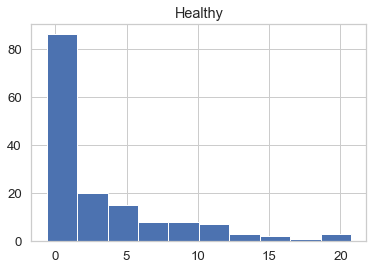

In [66]:
plt.hist(kcoh['kurt_healthy'])
plt.title('Healthy')
plt.show()

The most significant difference for _kurtosis_ appears for coherence (`coh`) features. On the other hand small difference coherence for alpha band. 
Small difference means that density functions look similar and therefore would not be a key feature.

**Relationship between new features**

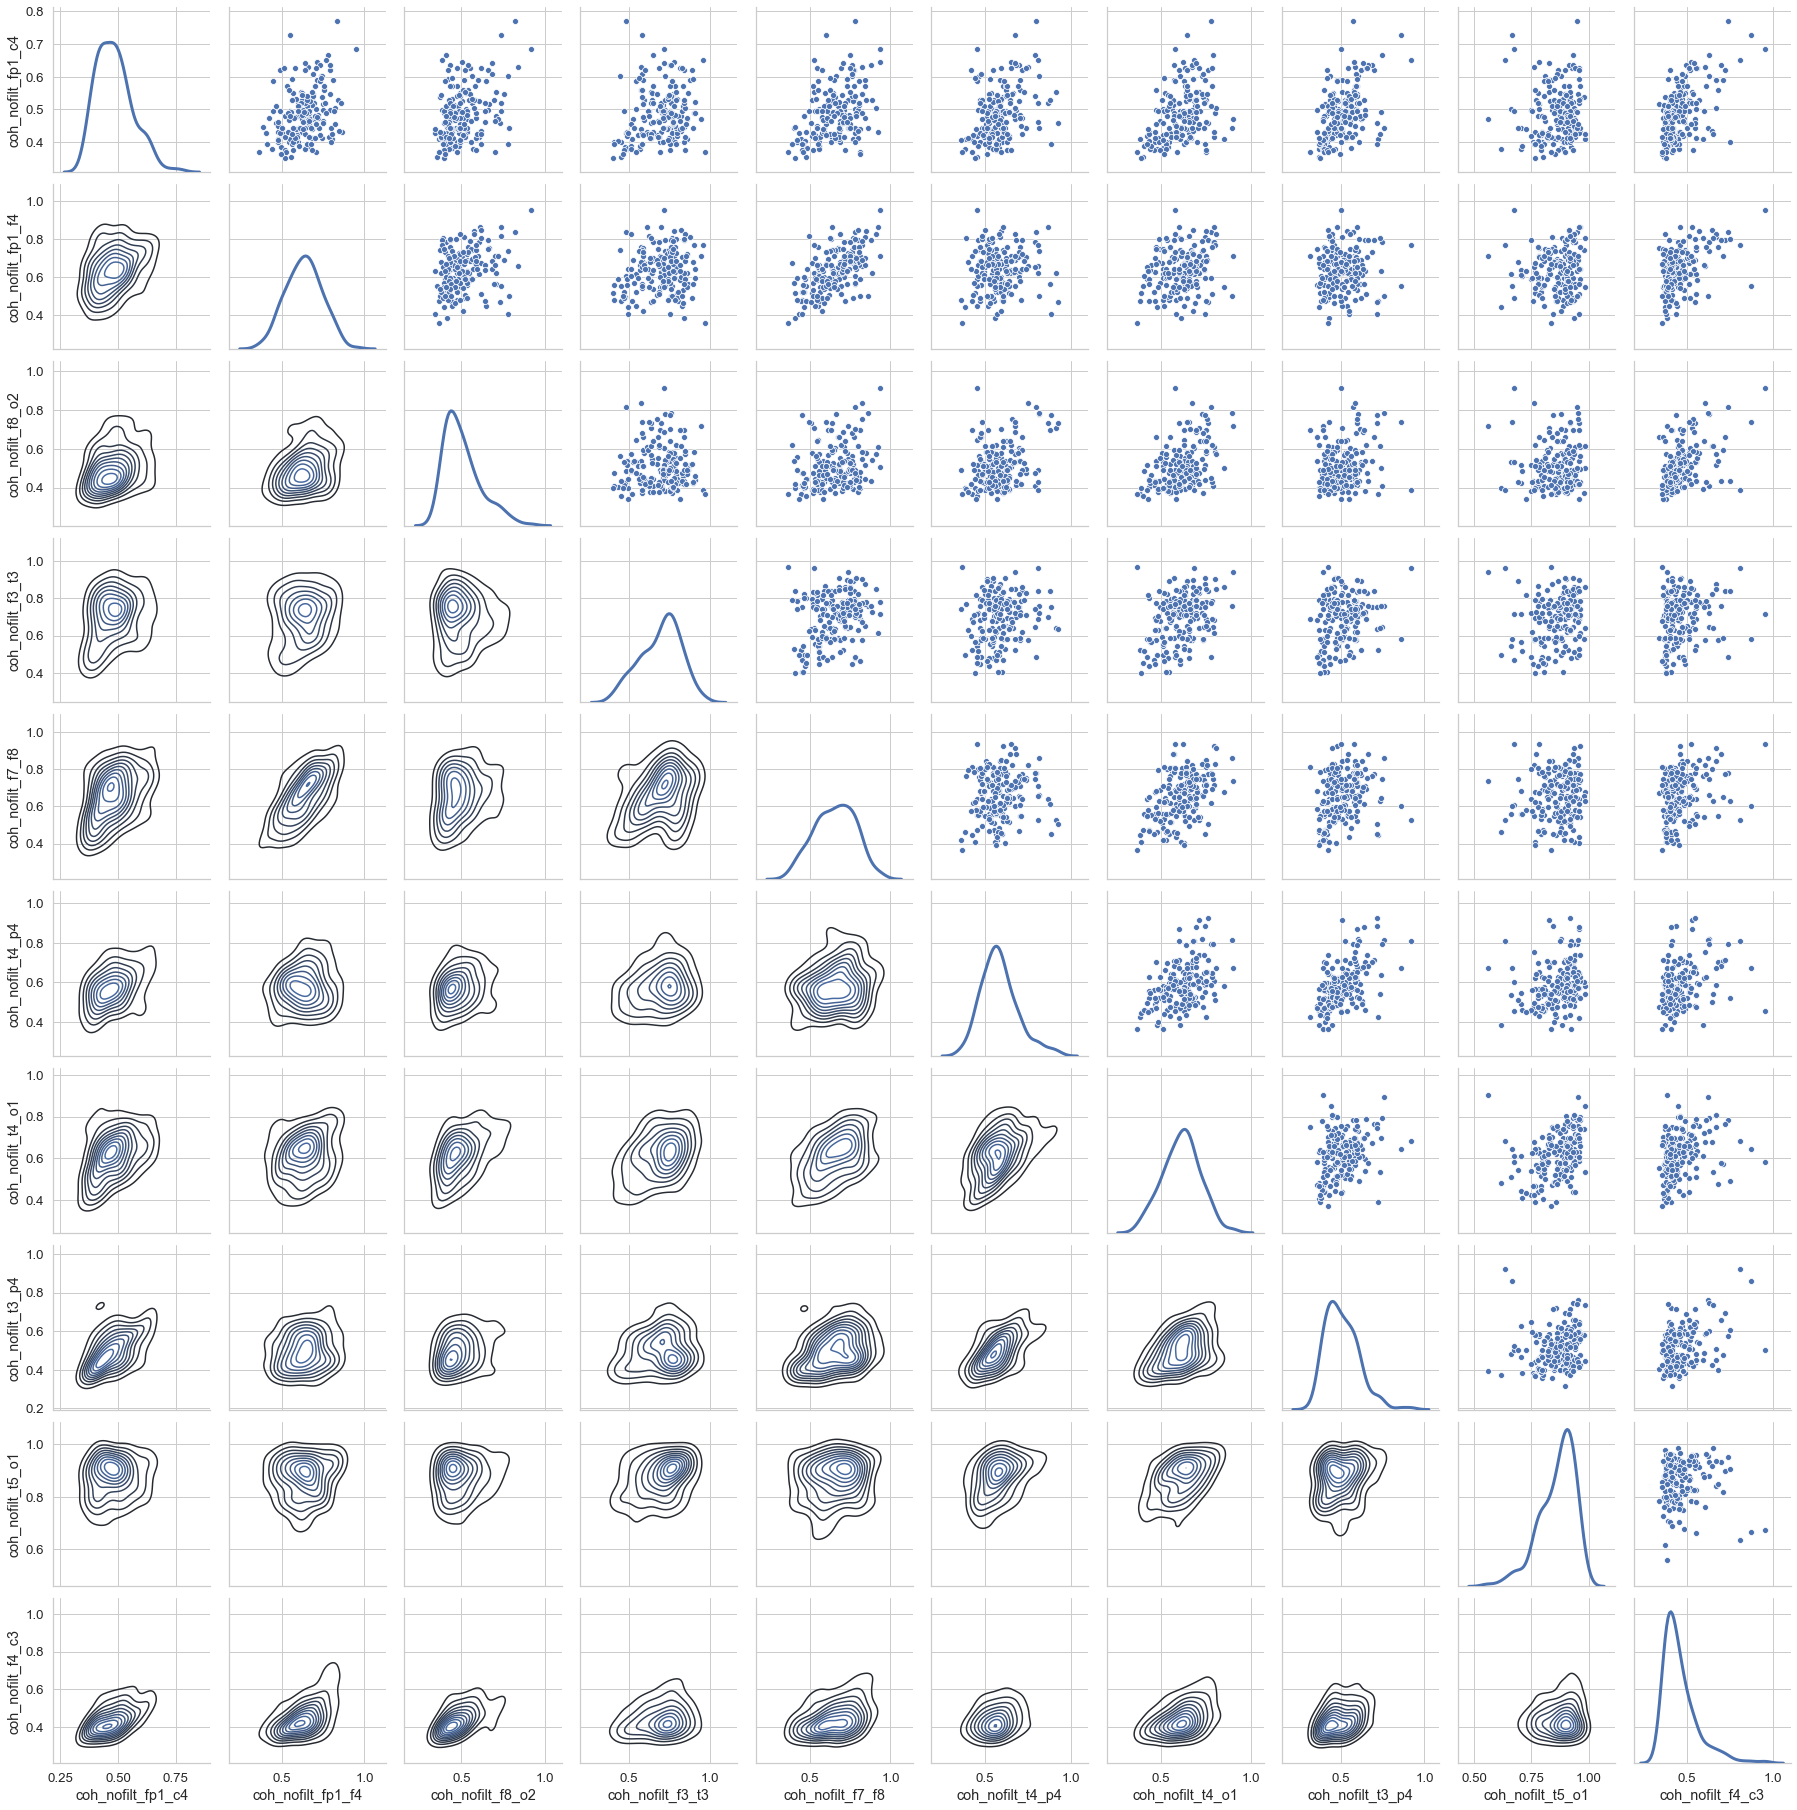

In [67]:
df = coh
feats = df[df.columns[~df.columns.isin(['fn','target'])]].columns.tolist()
features = random.choices(feats, k=10)

g = sns.PairGrid(df[features])
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

We can observe that there are no correlation(or litle) between the new features.

**Envelope**

In [68]:
def plot_box(df, features=None):
    if features==None:
        fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[25,12])
        sns.boxplot(data=df[df['target']=='trauma'], palette="Set3", orient='v', ax=axs[0])
        axs[0].set_ylabel(ylabel='Trauma', size=18)
        
        sns.boxplot(data=df[df['target']=='healthy'], palette="Set3", orient='v', ax=axs[1])
        axs[1].set_ylabel(ylabel='Healthy', size=18)
    else:
        fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[25,12])
        sns.boxplot(data=df[df['target']=='trauma'][features], palette="Set3", orient='v', ax=axs[0])
        axs[0].set_ylabel(ylabel='Trauma', size=18)

        sns.boxplot(data=df[df['target']=='healthy'][features], palette="Set3", orient='v', ax=axs[1])
        axs[1].set_ylabel(ylabel='Healthy', size=18)
        plt.title('Trauma')
    

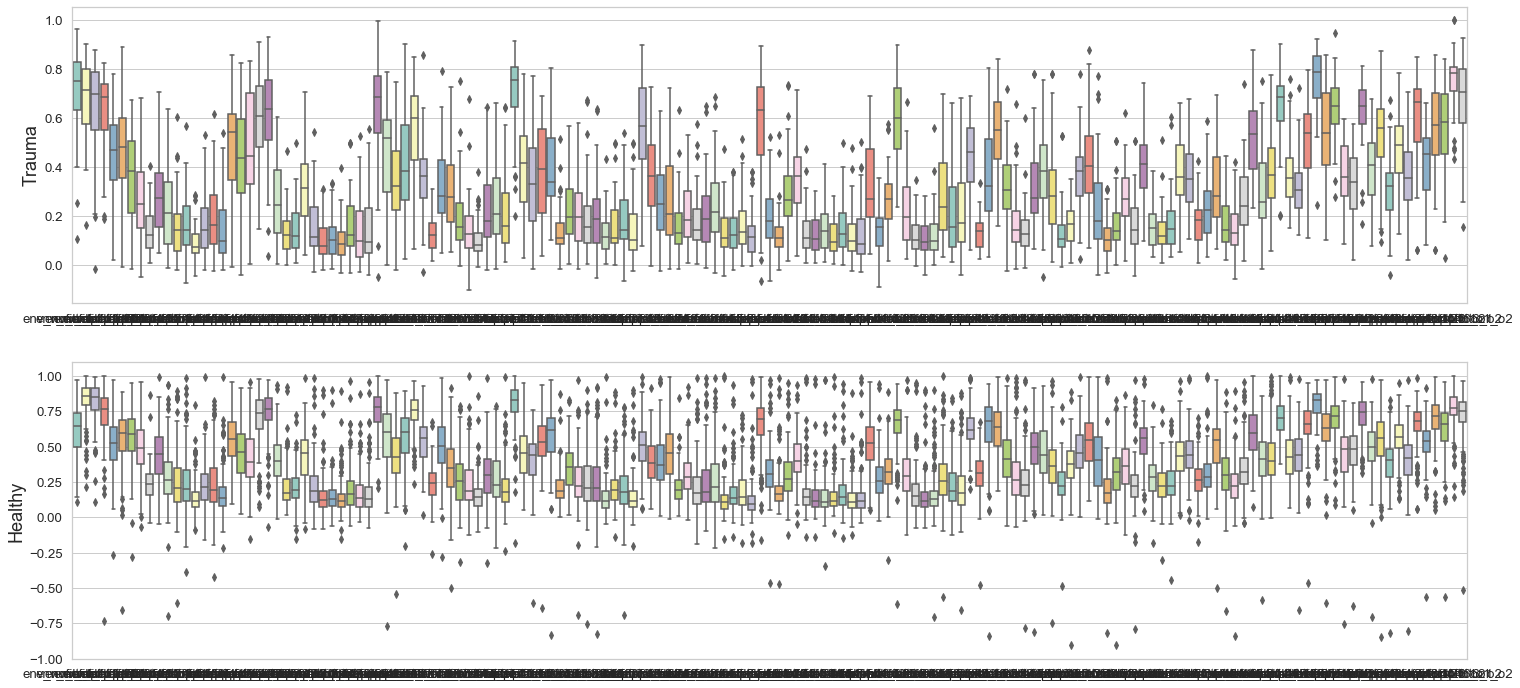

In [71]:
env = pd.read_csv('ml_data/env.csv')
plot_box(env)

Here we can see outliers for the healthy subjects in the lower quartiles.
I can't say what exactly could mean

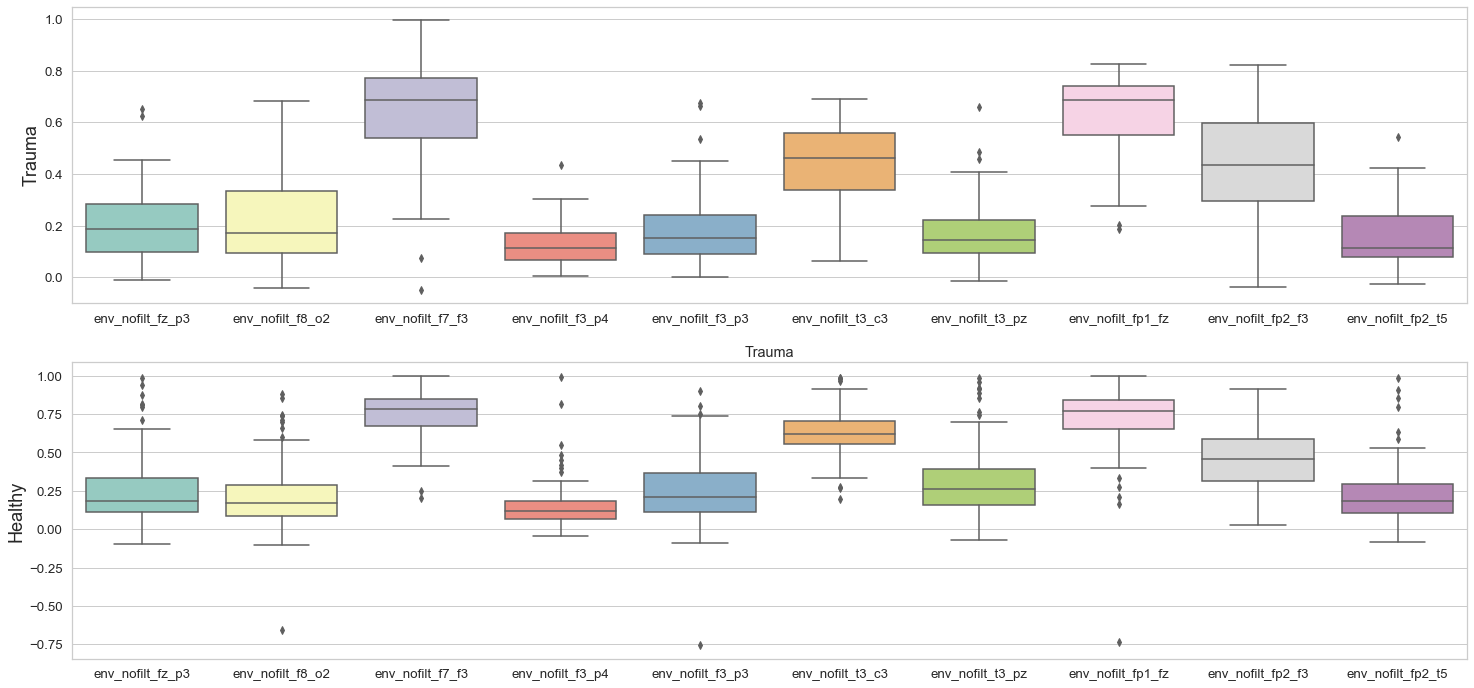

In [72]:
 # Box plot of envelope for a subset of features
df = env
feats = df[df.columns[~df.columns.isin(['fn','target'])]].columns.tolist()
features = random.choices(feats, k=10)

plot_box(env, features)

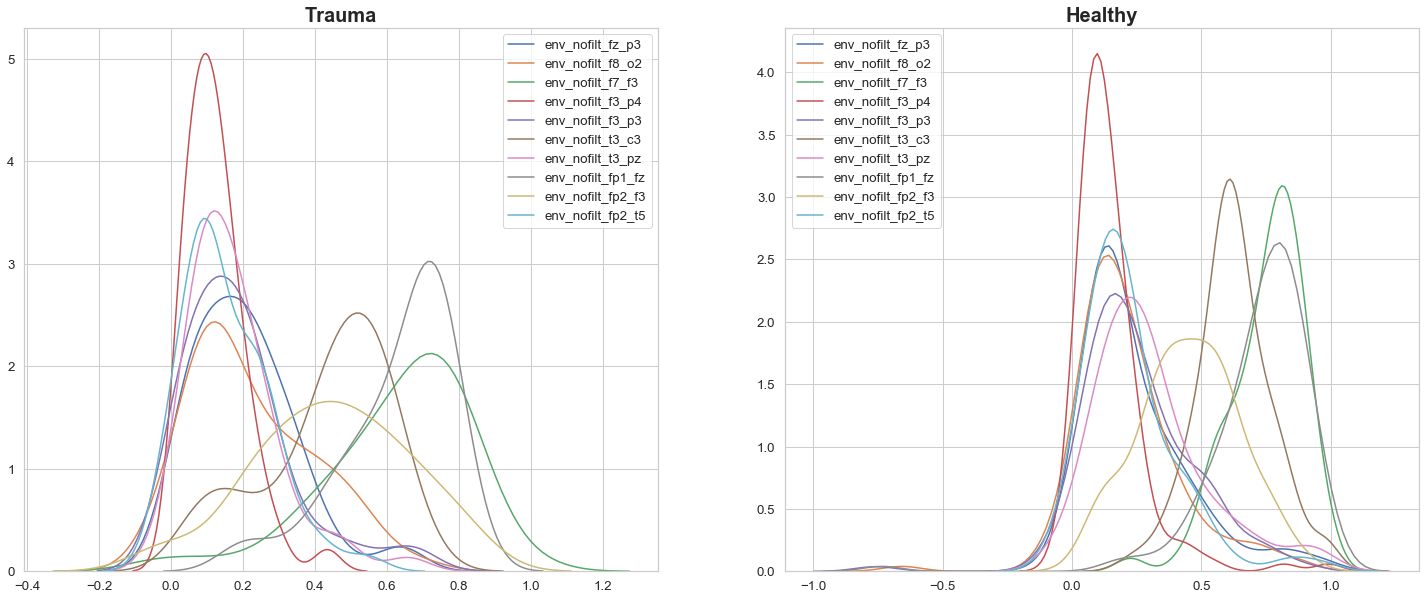

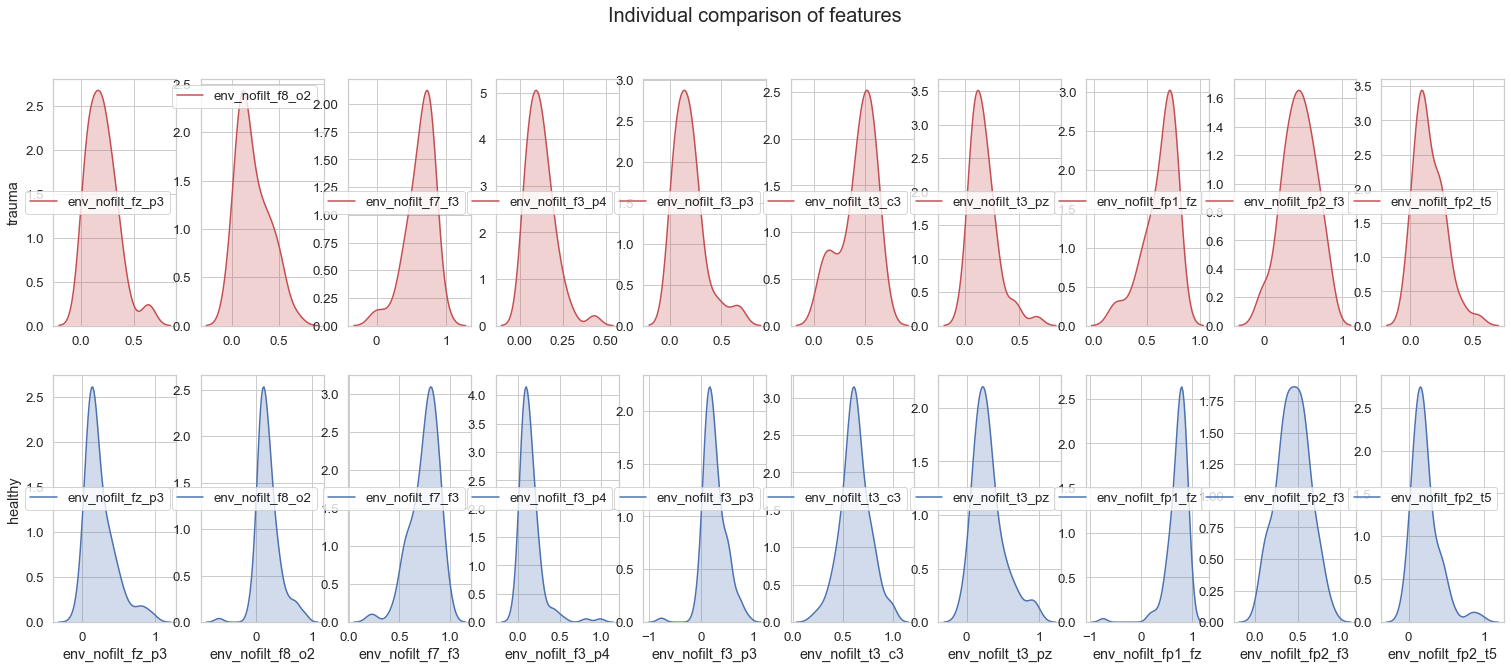

In [73]:
# Kde
plot_kde(df, features)

**Bands**

In [76]:
band = pd.read_csv('ml_data/bands.csv')

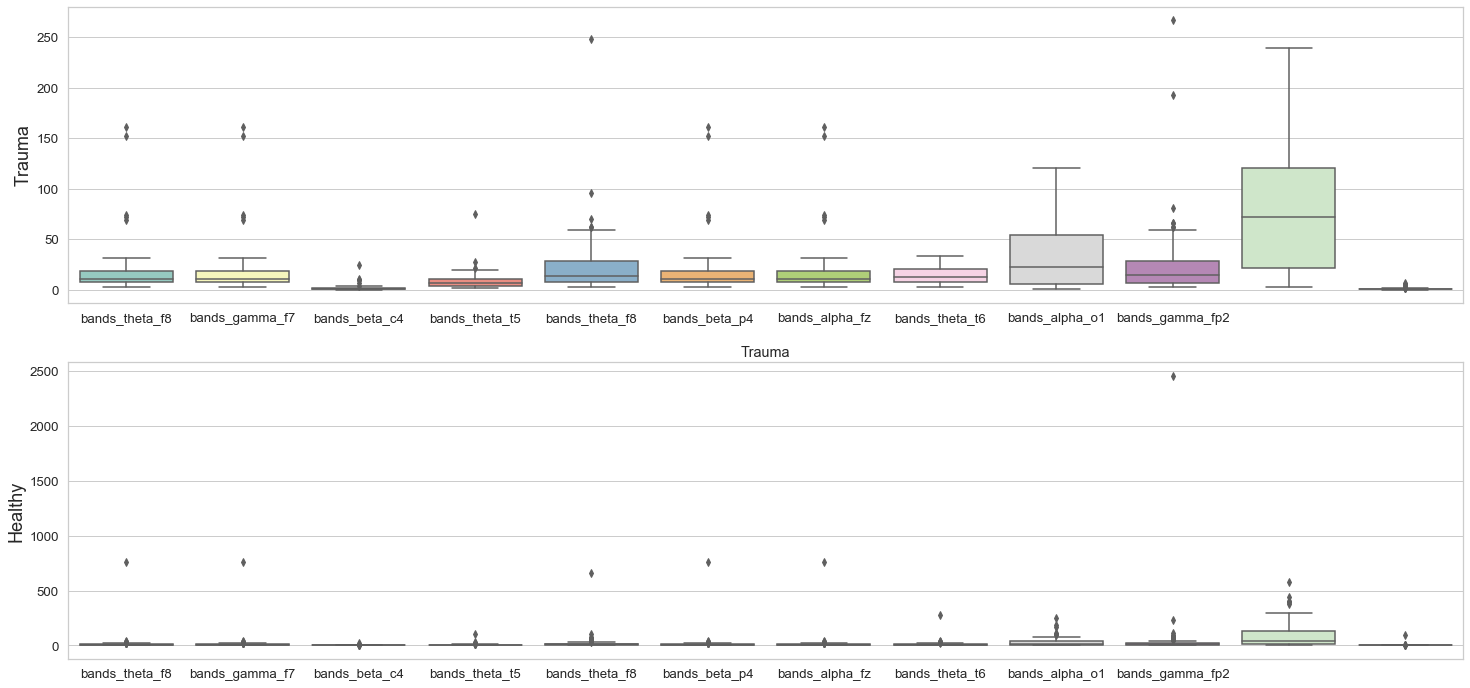

In [77]:
df = band
feats = df[df.columns[~df.columns.isin(['fn','target'])]].columns.tolist()
features = random.choices(feats, k=10)

plot_box(df, features)

Here there is also huge values in the band features for healthy patients.

It will be important to remove these outliers for the ML part

**Psi**

In [78]:
psi = pd.read_csv('ml_data/psi.csv')

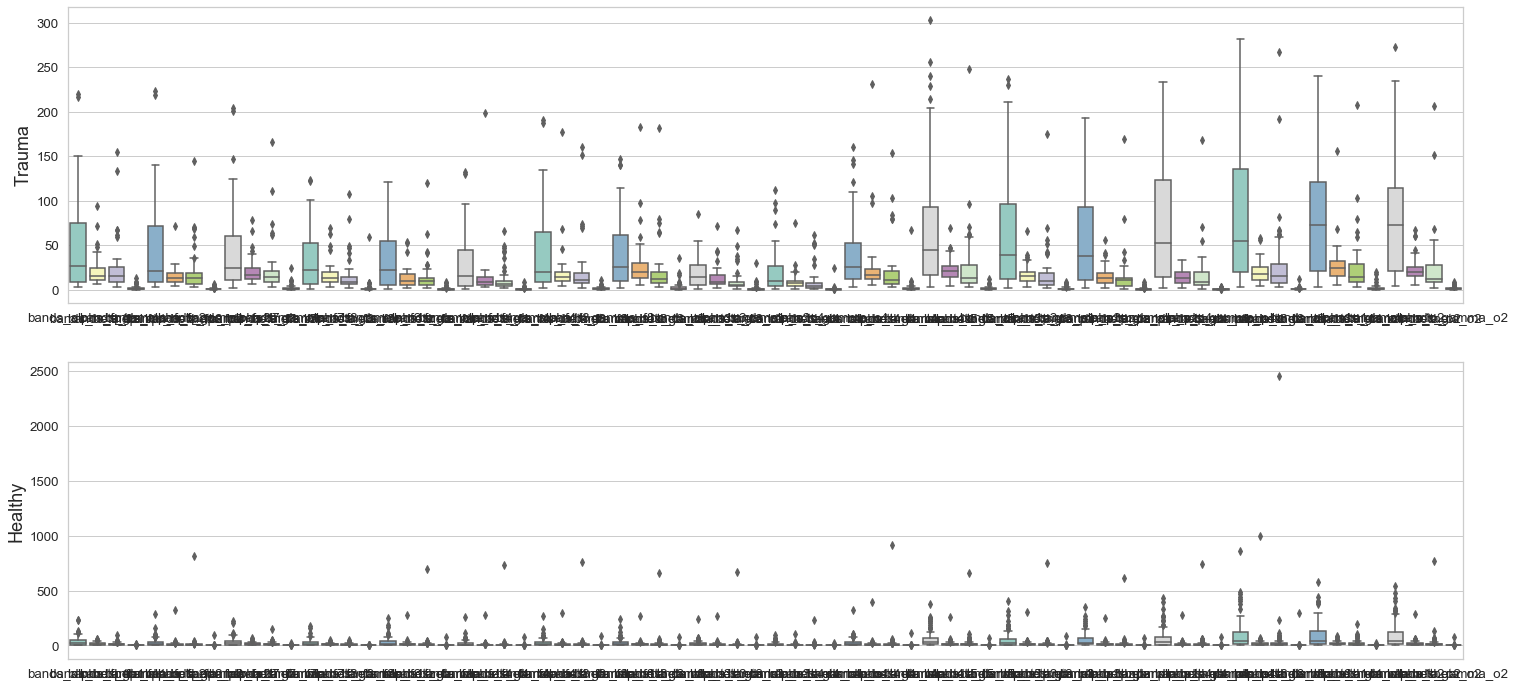

In [79]:
plot_box(df)

At first glance it might be a feature that doesn't help to the detection of helthy and trauma groups, since psi values are centered around zero and plots for both groups looks similar, it would be convenient to measure its standard deviation.

Concatenating all features into one single table

In [81]:
# path='ml_data/'

# meth_names=['coh','coh_alpha','coh_beta','coh_theta','env','env_alpha','env_beta','env_theta','bands','psi']
# lst_files=[]

# for l in meth_names:
#   lst_files.append(pd.read_csv(path+'{}.csv'.format(l)))

# df_features = pd.concat(lst_files, axis=1).T.drop_duplicates().T

# df_features.to_csv('mldataset/allfeatures.csv', index=False)

In [84]:
import pandas as pd

path = 'ml_data'

df_features = pd.read_csv(path+'/allfeatures.csv')
df_features['target'] = df_features['target'].apply(lambda x: 0 if x=='healthy' else 1 if x=='trauma' else None)
rocdata = feat_rocauc(df_features)
zdata = calc_zscore(df_features, path)

In [87]:
df_features

coh_nofilt_fp1_fp2  coh_nofilt_fp1_f7  coh_nofilt_fp1_f3  \
0              0.925107           0.910206           0.791667   
1              0.736159           0.852756           0.848469   
2              0.590307           0.759117           0.684606   
3              0.922378           0.956236           0.938099   
4              0.713762           0.700639           0.485828   
..                  ...                ...                ...   
180            0.681507           0.976029           0.990875   
181            0.716511           0.865623           0.822787   
182            0.869927           0.614489           0.836711   
183            0.857613           0.776332           0.625418   
184            0.902358           0.613809           0.823831   

     coh_nofilt_fp1_fz  coh_nofilt_fp1_f4  coh_nofilt_fp1_f8  \
0             0.786606           0.606870           0.826563   
1             0.832023           0.735646           0.699284   
2             0.835561           0.441914           0.471128   
3             0.884203           0.809903           0.859925   
4             0.457860           0.477659           0.546004   
..                 ...                ...                ...   
180           0.980288           0.665782           0.686938   
181           0.779885           0.630896           0.633906   
182           0.535884           0.728975           0.659765   
183           0.757507           0.701859           0.655832   
184           0.808262           0.665335           0.452052   

     coh_nofilt_fp1_t3  coh_nofilt_fp1_c3  coh_nofilt_fp1_c4  \
0             0.596338           0.383903           0.427939   
1             0.717863           0.750833           0.602948   
2             0.694776           0.525075           0.378014   
3             0.873840           0.750620           0.590392   
4             0.461389           0.457423           0.398958   
..                 ...                ...                ...   
180           0.658713           0.569178           0.416173   
181           0.701499           0.723714           0.461858   
182           0.584520           0.456099           0.420763   
183           0.729231           0.371244           0.411272   
184           0.639332           0.649139           0.463719   

     coh_nofilt_fp1_t4  ...  psi_alpha_o2_t3  psi_alpha_o2_c3  \
0             0.758854  ...         0.589972         1.627634   
1             0.667335  ...        -1.450037        -0.716801   
2             0.486828  ...         0.909508        -0.790305   
3             0.815615  ...         3.169365         1.445172   
4             0.399803  ...         3.307492         3.972280   
..                 ...  ...              ...              ...   
180           0.612464  ...         0.524004         0.751278   
181           0.586057  ...         3.029100        -2.671962   
182           0.530364  ...         0.948921        -0.455320   
183           0.419932  ...         0.140317        -0.044274   
184           0.566678  ...        -0.451442         0.496673   

     psi_alpha_o2_c4  psi_alpha_o2_t4  psi_alpha_o2_t5  psi_alpha_o2_p3  \
0           1.139019         0.161162         0.343749         1.730590   
1           0.180625        -2.210631        -1.151112        -4.492981   
2           0.857226         0.921500         0.977153        -1.578377   
3          -0.557241        -0.140675        -1.310494         1.707771   
4           3.881311         4.463736         0.579768         2.091910   
..               ...              ...              ...              ...   
180         2.314810         0.436194         0.685202        -1.034235   
181        -0.211394         4.874666         4.768721        -1.390298   
182        -4.817190         0.418351        -0.073473        -1.036244   
183         2.917813         0.728432         0.273883         0.256836   
184        -1.334246        -1.417780        -1.452185        -0.912683   

    

In [88]:
rocdata

feature   roc_auc  mean_difference
1018      env_beta_t3_t4  0.900205        -0.334692
1027      env_beta_c3_t4  0.884109        -0.192037
1017      env_beta_t3_c4  0.880451        -0.162736
721     env_nofilt_c3_t4  0.877231        -0.199189
406       coh_beta_t3_t4  0.877085        -0.206153
...                  ...       ...              ...
0     coh_nofilt_fp1_fp2  0.501024         0.001862
682     env_nofilt_fz_pz  0.500878        -0.023256
1430     psi_alpha_o1_p4  0.500585         0.052048
238      coh_alpha_f4_o1  0.500293         0.007106
630    env_nofilt_fp2_f3  0.500000        -0.004793

[1449 rows x 3 columns]

In [89]:
zdata

coh_nofilt_fp1_fp2  coh_nofilt_fp1_f7  coh_nofilt_fp1_f3  \
0              1.608561           0.451766          -0.550903   
1              0.054480          -0.124067          -0.059056   
2             -1.145135          -1.062645          -1.477934   
3              1.586114           0.913152           0.717041   
4             -0.129727          -1.648795          -3.199134   
..                  ...                ...                ...   
180           -0.395021           1.111542           1.174024   
181           -0.107117           0.004898          -0.281434   
182            1.154710          -2.512307          -0.160865   
183            1.053426          -0.890101          -1.990434   
184            1.421453          -2.519129          -0.272394   

     coh_nofilt_fp1_fz  coh_nofilt_fp1_f4  coh_nofilt_fp1_f8  \
0            -0.414060          -0.252501           1.358532   
1             0.021310           0.936015           0.260220   
2             0.055225          -1.774937          -1.708560   
3             0.521515           1.621356           1.646409   
4            -3.565460          -1.445035          -1.062453   
..                 ...                ...                ...   
180           1.442593           0.291214           0.153686   
181          -0.478489          -0.030757          -0.303929   
182          -2.817506           0.874444          -0.080795   
183          -0.693009           0.624176          -0.114732   
184          -0.206470           0.287085          -1.873172   

     coh_nofilt_fp1_t3  coh_nofilt_fp1_c3  coh_nofilt_fp1_c4  \
0            -0.930237          -2.047987          -0.737829   
1             0.004739           0.491173           1.490659   
2            -0.172889          -1.071076          -1.373541   
3             1.204766           0.489697           1.330770   
4            -1.968484          -1.539230          -1.106857   
..                 ...                ...                ...   
180          -0.450342          -0.765887          -0.887639   
181          -0.121162           0.303504          -0.305909   
182          -1.021157          -1.548391          -0.829198   
183           0.092194          -2.135588          -0.950052   
184          -0.599455          -0.212552          -0.282221   

     coh_nofilt_fp1_t4  ...  psi_alpha_o2_c3  psi_alpha_o2_c4  \
0             1.241828  ...         0.758054         0.559945   
1             0.458341  ...        -0.329123         0.123078   
2            -1.086967  ...        -0.363209         0.431495   
3             1.727752  ...         0.673441        -0.213266   
4            -1.831981  ...         1.845328         1.809974   
..                 ...  ...              ...              ...   
180          -0.011412  ...         0.351664         1.095910   
181          -0.237474  ...        -1.235784        -0.055617   
182          -0.714262  ...        -0.207868        -2.155092   
183          -1.659658  ...        -0.017255         1.370779   
184          -0.403379  ...         0.233596        -0.567451   

     psi_alpha_o2_t4  psi_alpha_o2_t5  psi_alpha_o2_p3  psi_alpha_o2_pz  \
0           0.053426         0.298466         1.078347         1.078232   
1          -1.125536        -0.933681        -2.712807        -1.008194   
2           0.431373         0.820552        -0.937345        -1.126749   
3          -0.096609        -1.065053         1.064447         0.121936   
4           2.192134         0.493005         1.298449         1.235113   
..               ...              ...              ...              ...   
180         0.190138         0.579910        -0.605875         0.246202   
181         2.396398         3.945771        -0.822775        -0.642723   
182         0.181269        -0.045432        -0.607099         0.014361   
183         0.335403         0.240879         0.180595        -0.701576   
184        -0.731428        -1.181842        -0.531831        -0.418996   

    

# 2) Statistical Analysis

* Generate a distribution of z_score (mean_1 - mean_2)/std or roc_auc (equals to Mann-Wittney U) for a random feature

* Generate healthy, generate trauma. compute z-score. remember. do 10000 times
I have z-score 1.96 for my coh_alpha_f3_f4. What does it mean? I have probability of 0.03 percent have as extreme value of statistic or higher = p-value
I have z-scores of [2.00, 2.05, 2.50] for my three features. Which probability to have it?

* Use bonferonni correction (or something else)

* Correlation matrix

In [93]:
#! pip install statsmodels

In [103]:
import pandas as pd
from scipy import stats
from statsmodels.stats import weightstats as stests
from statsmodels.sandbox.stats.multicomp import multipletests

In [142]:
feat1 = zdata['coh_beta_t3_t4']
feat2 = zdata['env_nofilt_fp2_f3']

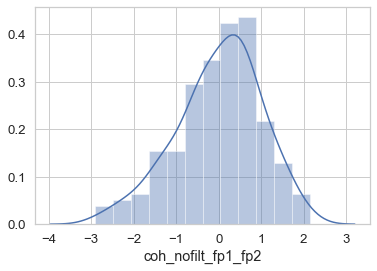

In [127]:
sns.distplot(zdata['coh_nofilt_fp1_fp2'])

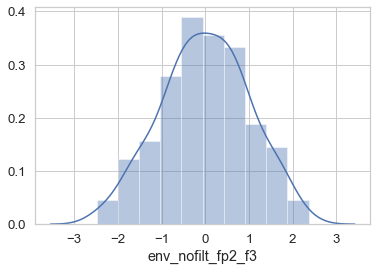

In [140]:
sns.distplot(feat2)

In [137]:
def t_test_function(rvs, alpha, no_test):
    counter = 0
    pvalue_ = 0
    for i in range(no_test):
        rvs_random = stats.norm.rvs(loc=np.mean(rvs), scale=np.std(rvs), size=len(rvs), random_state=i+1)

        statistic, pvalue = stats.ttest_ind(rvs, rvs_random, equal_var=False)

        if pvalue <= alpha:
            counter = counter + 1
            pvalue_ = pvalue

    print(counter, pvalue_)

In [136]:
def bonferroni_correction_function(rvs, alpha, no_test):
    alpha_bonferroni = alpha/no_test
    
    counter = 0
    pvalue_ = 0
    for i in range(no_test):
        rvs_random = stats.norm.rvs(loc=np.mean(rvs), scale=np.std(rvs), size=len(rvs), random_state=i+1)

        statistic, pvalue = stats.ttest_ind(rvs, rvs_random, equal_var=False)

        if pvalue <= alpha_bonferroni:
            counter = counter + 1
            pvalue_ = pvalue

    print(counter, pvalue_)

In [143]:
#T test for coh_nofilt_fp1_fp2
t_test_function(feat1, alpha=0.05, no_test=10000)

bonferroni_correction_function(feat1, alpha=0.05, no_test=10000)

56 0.04397543152814695
0 0


In [141]:
#T test for env_nofilt_fp2_f3
t_test_function(feat2, alpha=0.05, no_test=10000)

bonferroni_correction_function(feat2, alpha=0.05, no_test=10000)

56 0.04397543152814702
0 0


After the correction of pvalues, it is not statistically significant for these two variables

# 3) Exploratory Analysis

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def get_correlated_pairs(threshold, correlation_df, group):
    ## create dictionary wheke keys are the pairs and values are the amount of high correlation pair
    
    corr_pairs_dict = {}
    for i in range(len(list_of_pairs)):
        temp_corr_pair = dict(zip(list_of_pairs[i], [0]))
        corr_pairs_dict.update(temp_corr_pair)

    j = 0
    for column in correlation_df.columns:
        j += 1
        for i in range(j, len(correlation_df)):
            if ((correlation_df[column][i] >= threshold) & (column != correlation_df.index[i])):
                corr_pairs_dict[column + '-' + correlation_df.index[i]] += 1

    corr_count = pd.DataFrame(corr_pairs_dict, index=['count']).T.reset_index(drop=False).rename(columns={'index': 'feat_pair'})
    lst_corr = corr_count['feat_pair'][corr_count['count'] > 0].tolist()
    print('Features pairs that have correlation value >= ' + str(threshold) + ' (' + group + ' group):')
    print(lst_corr)

    return lst_corr

In [145]:
correlations_trauma = df_features[df_features['target'] == 1].corr()
correlations_healthy = df_features[df_features['target'] == 0].corr()

list_of_pairs = [] ## create the list of possible features pairs
j = 0
for column in correlations_trauma.columns:
    j += 1
    for i in range(j, len(correlations_trauma)):
        if column != correlations_trauma.index[i]:
            temp_pair = [column + '-' + correlations_trauma.index[i]]
            list_of_pairs.append(temp_pair)

corr_trauma = get_correlated_pairs(threshold=0.95, correlation_df=correlations_trauma, group='trauma')
print('\n')
corr_healthy = get_correlated_pairs(threshold=0.95, correlation_df=correlations_healthy, group='healthy')

#plot_correlation(df=df_features, threshold_value=.97)

Features pairs that have correlation value >= 0.95 (trauma group):
['coh_nofilt_fp2_t5-coh_nofilt_fp2_o1', 'coh_nofilt_f7_p3-coh_nofilt_f3_p3', 'coh_nofilt_f3_p3-coh_nofilt_f3_pz', 'coh_nofilt_f4_t5-coh_nofilt_f4_o1', 'coh_alpha_fp1_fp2-env_alpha_fp1_fp2', 'coh_alpha_fp1_c3-coh_alpha_f3_c3', 'coh_alpha_fp1_c4-coh_alpha_f7_c4', 'coh_alpha_fp1_t4-coh_alpha_f7_t4', 'coh_alpha_fp1_t5-coh_alpha_f3_t5', 'coh_alpha_fp1_p3-coh_alpha_f3_p3', 'coh_alpha_fp1_pz-coh_alpha_f3_pz', 'coh_alpha_fp1_t6-coh_alpha_f7_t6', 'coh_alpha_fp1_o1-coh_alpha_f7_o1', 'coh_alpha_fp1_o1-coh_alpha_f3_o1', 'coh_alpha_fp1_o2-coh_alpha_fp2_o2', 'coh_alpha_fp1_o2-coh_alpha_f7_o2', 'coh_alpha_fp2_o1-coh_alpha_f4_o1', 'coh_alpha_fp2_o2-coh_alpha_f4_o2', 'coh_alpha_f3_t5-coh_alpha_f3_o1', 'coh_alpha_fz_t5-coh_alpha_fz_o1', 'coh_alpha_f4_t5-coh_alpha_f4_o1', 'coh_beta_fp1_c3-coh_beta_fz_c3', 'coh_beta_fp1_c4-coh_beta_f7_c4', 'coh_beta_fp1_t5-coh_beta_f7_p3', 'coh_beta_fp1_p3-coh_beta_fp1_pz', 'coh_beta_fp1_p3-coh_beta_f7_p3'

# 4) ML features selection

> Drop Features with correlation > 0.75

In [146]:
correlated_features = set()
correlation_matrix = df_features.corr()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.75:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

print('%i features in train dataset have correlation > 0.75' % (len(correlated_features)))
#print(correlated_features)

1172 features in train dataset have correlation > 0.75


### Apply RFE: Recursive feature elimination.

this were used to find the minimal features able to given us a better classification report

In [147]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.exceptions import ConvergenceWarning
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=ConvergenceWarning)

In [148]:
X = df_features.drop(['fn','target'], axis=1)
y = df_features.target

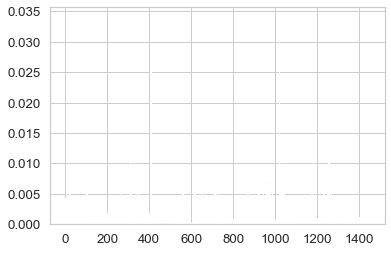

In [149]:
rfc = RandomForestClassifier(random_state=101, class_weight='balanced')
rfc.fit(X, y)
importance = rfc.feature_importances_

for i,v in enumerate(importance):
  if v > 0.3:
	  print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [150]:
rfc = RandomForestClassifier(random_state=101, class_weight='balanced')
kfold = StratifiedKFold(n_splits=5, shuffle=True) 
cv = kfold.split(X, y)
rfecv = RFECV(estimator=rfc, step=10, min_features_to_select=20, cv=cv)
%time rfecv.fit(X, y)

CPU times: user 2min 19s, sys: 929 ms, total: 2min 19s
Wall time: 2min 20s


RFECV(cv=<generator object _BaseKFold.split at 0x7f9d0aa7f5d0>,
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight='balanced',
                                       criterion='gini', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=101,
                                       verbose=0, warm_start=False),
      min_features_to_select=20, n_jobs=None, scoring=None, step=10, verbose=0)

In [ ]:
rfc = RandomForestClassifier(random_state=101, class_weight='balanced')
kfold = StratifiedKFold(n_splits=5, shuffle=True) 
cv = kfold.split(X, y)
rfecv = RFECV(estimator=rfc, step=10, min_features_to_select=20, cv=cv)
%time rfecv.fit(X, y)

CPU times: user 2min 58s, sys: 506 ms, total: 2min 58s
Wall time: 2min 58s


RFECV(cv=<generator object _BaseKFold.split at 0x7fcccf041c50>,
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight='balanced',
                                       criterion='gini', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=101,
                                       verbose=0, warm_start=False),
      min_features_to_select=20, n_jobs=None, scoring=None, step=10, verbose=0)

In [151]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 129


In [ ]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 309


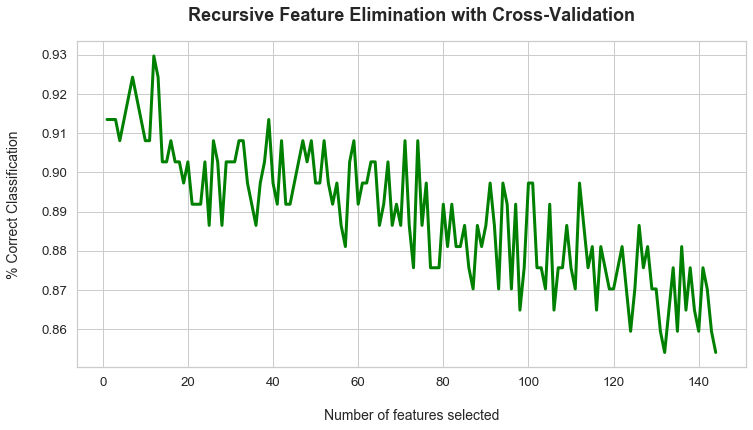

In [152]:
plt.figure(figsize=(12, 6))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='green', linewidth=3)
plt.show()

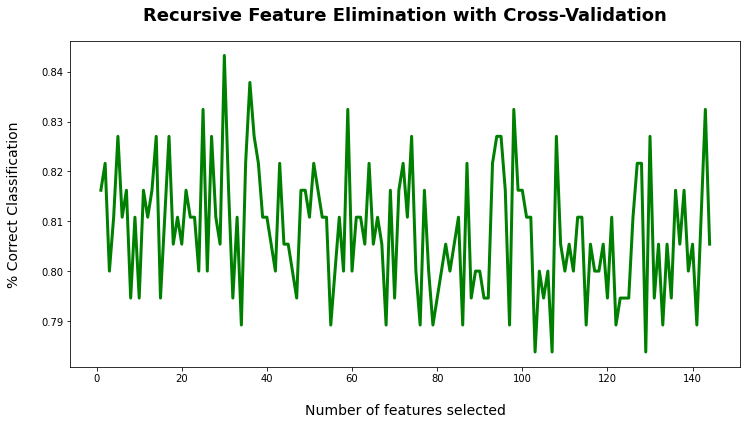

In [ ]:
plt.figure(figsize=(12, 6))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='green', linewidth=3)
plt.show()

In [153]:
#print(np.where(rfecv.support_ == False)[0])

X2 = X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1)

In [ ]:
#print(np.where(rfecv.support_ == False)[0])

X2 = X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1)

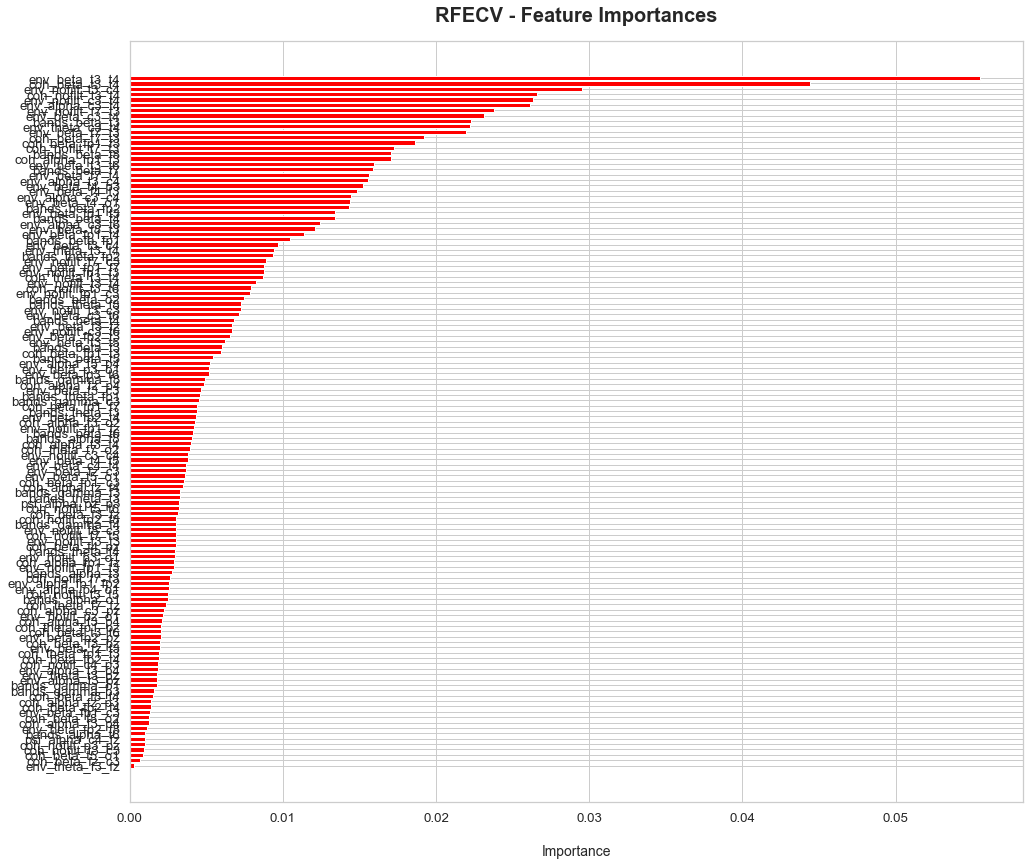

In [154]:
dset = pd.DataFrame()

dset['attr'] = X2.columns
dset['importance'] = rfecv.estimator_.feature_importances_
dset = dset.sort_values(by='importance', ascending=True)
plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='red')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

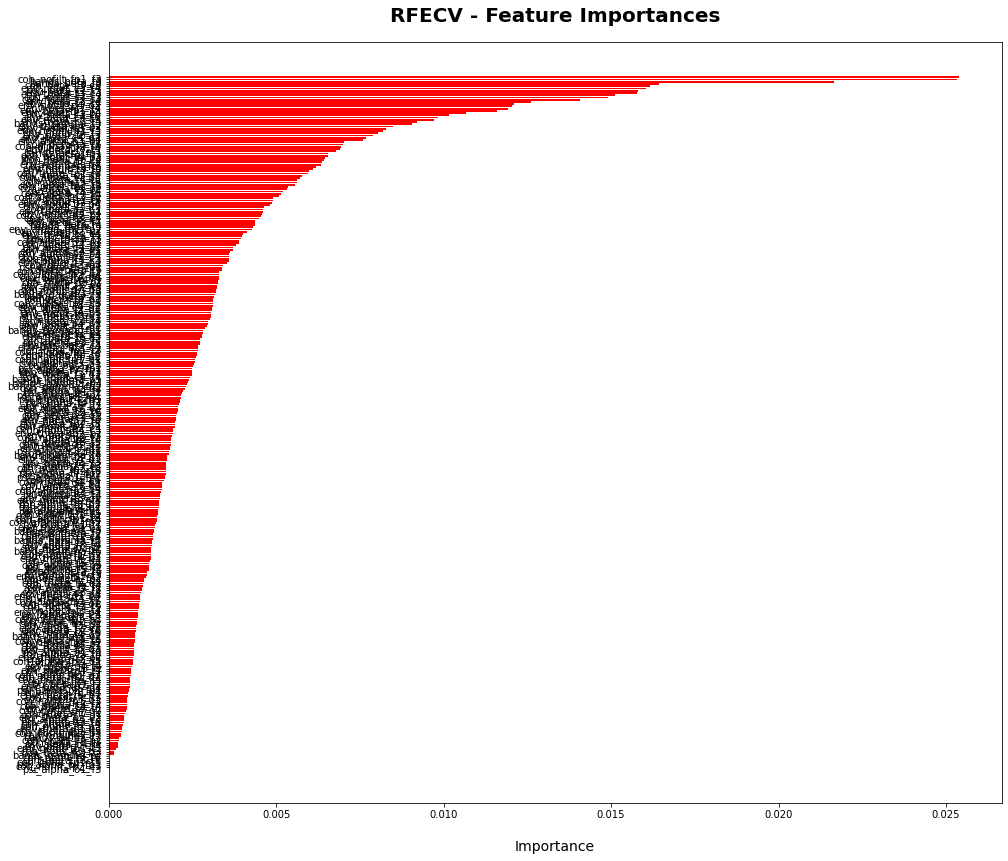

In [ ]:
dset = pd.DataFrame()

dset['attr'] = X2.columns
dset['importance'] = rfecv.estimator_.feature_importances_
dset = dset.sort_values(by='importance', ascending=True)
plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='red')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

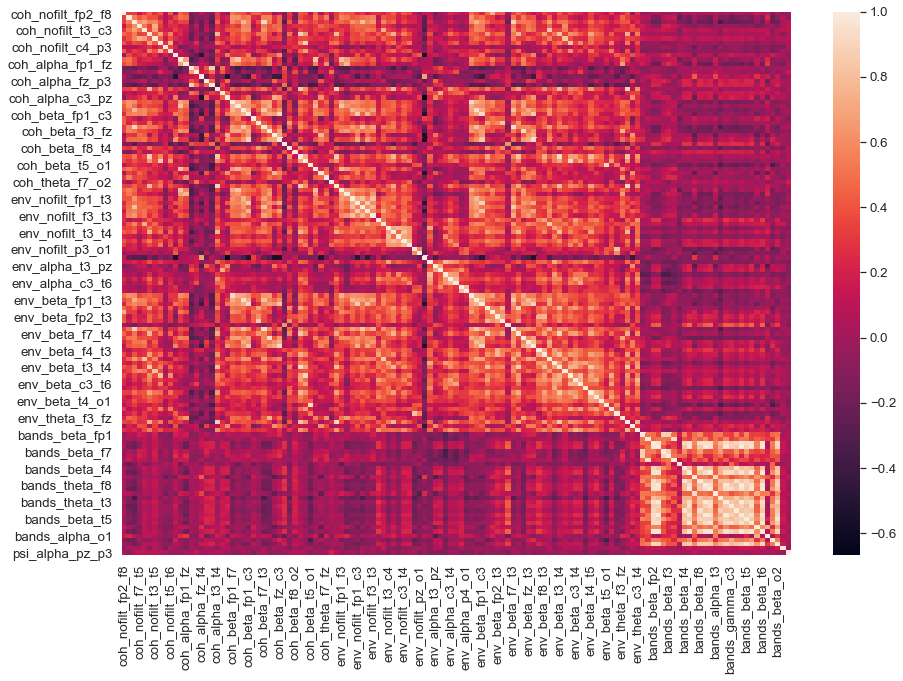

In [155]:
corrmap = X2.corr().drop_duplicates()
plt.figure(figsize=[15,10])
sns.heatmap(corrmap, cbar=True)

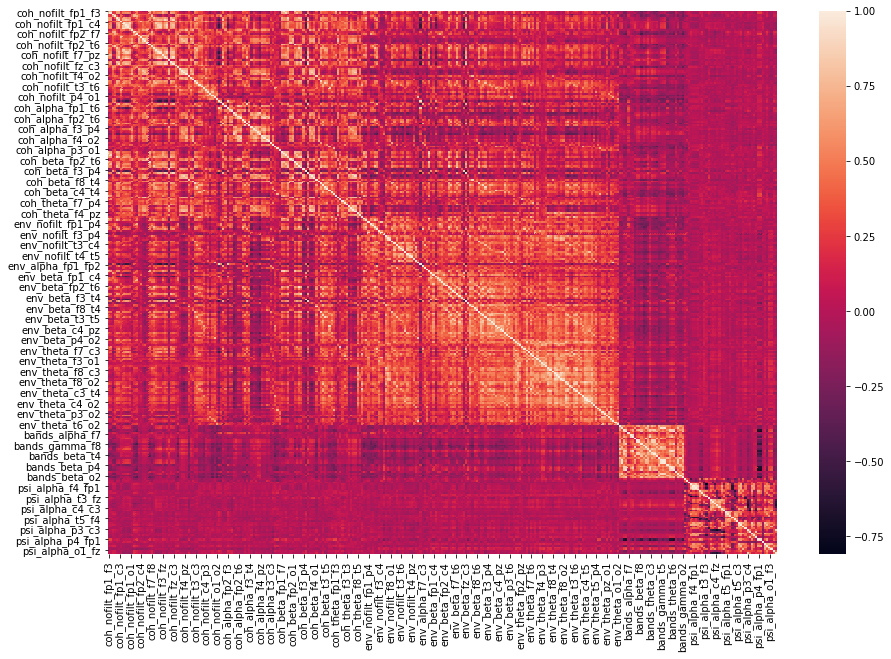

In [ ]:
corrmap = X2.corr().drop_duplicates()
plt.figure(figsize=[15,10])
sns.heatmap(corrmap, cbar=True)

In [156]:
X2[['fn','target']] = df_features[['fn','target']]
X2

coh_nofilt_fp2_f8  coh_nofilt_f7_f3  coh_nofilt_f7_t3  coh_nofilt_f7_t5  \
0             0.898959          0.708213          0.745451          0.551259   
1             0.821351          0.837714          0.801349          0.805891   
2             0.627041          0.552460          0.749100          0.596588   
3             0.901875          0.950780          0.943904          0.798676   
4             0.669300          0.574855          0.609371          0.429392   
..                 ...               ...               ...               ...   
180           0.808646          0.986471          0.764094          0.556343   
181           0.747423          0.857544          0.874634          0.591820   
182           0.629094          0.695265          0.652384          0.565711   
183           0.777284          0.621506          0.761178          0.402753   
184           0.550954          0.761113          0.959123          0.930669   

     coh_nofilt_t3_c3  coh_nofilt_t3_t4  coh_nofilt_t3_t5  coh_nofilt_t3_t6  \
0            0.581465          0.754051          0.688510          0.588942   
1            0.744514          0.650385          0.783752          0.642973   
2            0.505669          0.551182          0.686000          0.591421   
3            0.865162          0.824546          0.863728          0.676856   
4            0.503848          0.424970          0.513524          0.449774   
..                ...               ...               ...               ...   
180          0.672812          0.828388          0.819582          0.789529   
181          0.881394          0.751821          0.811235          0.551895   
182          0.668599          0.630385          0.725036          0.677443   
183          0.611266          0.437993          0.673949          0.388979   
184          0.845448          0.724024          0.926595          0.531510   

     coh_nofilt_c4_p3  coh_nofilt_t5_t6  ...  bands_gamma_p3  bands_alpha_t6  \
0            0.374822          0.764996  ...        0.574888       24.443810   
1            0.652106          0.749840  ...        0.045172       55.977540   
2            0.389563          0.583709  ...        7.246699       39.635000   
3            0.366865          0.726732  ...        0.107074      113.937982   
4            0.436716          0.670137  ...        0.131500       21.527182   
..                ...               ...  ...             ...             ...   
180          0.587434          0.892181  ...        0.372073       68.217877   
181          0.610649          0.742634  ...        0.883916        4.777362   
182          0.474455          0.870580  ...        0.387391       25.329833   
183          0.386523          0.478244  ...        1.971604      407.507288   
184          0.416921          0.565052  ...        7.918725       37.035273   

     bands_beta_t6  bands_alpha_o1  bands_gamma_o1  bands_beta_o2  \
0        14.672073       22.853672        0.787576      11.553152   
1        28.794784       85.863173        0.167025      31.411912   
2        11.160918       51.235402       19.754951      20.405893   
3        22.749786       79.578831        0.116438      23.191103   
4         7.231482       14.783130        0.481252       6.826721   
..             ...             ...             ...            ...   
180      15.747577      107.894848        0.758138      17.706730   
181       8.292166       14.857729        1.253049       9.081738   
182       6.417887       25.829750        0.722493       6.207193   
183      26.820247      233.941636        0.756009      13.533132   
184      19.740448       62.427705        7.060864      38.362795   

     psi_alpha_c4_fz  psi_alpha_pz_p3                    fn  target  
0          -0.453495        -0.040627  b906373005ba09e6.csv       1  
1          -1.310173        -3.639103  bc8568311c86157d.csv       1  
2          -0.292522         0.585621  5c9ca89c610ef553.csv       1  
3           2.041392     

In [ ]:
X2[['fn','target']] = df_features[['fn','target']]
X2

coh_nofilt_fp1_f3  coh_nofilt_fp1_fz  ...                    fn  target
0             0.857365           0.864015  ...  00b2d6e257e2f615.csv       1
1             0.775378           0.657702  ...  09769097749fb286.csv       1
2             0.861601           0.828406  ...  0b84dd748e7d5edd.csv       1
3             0.833709           0.886321  ...  158ce5e17a662599.csv       1
4             0.887078           0.892046  ...  17df70855fa4922a.csv       1
..                 ...                ...  ...                   ...     ...
180           0.576064           0.494556  ...  b5abacb75ebc40b8.csv       0
181           0.384045           0.431943  ...  bb47addde80c51c0.csv       0
182           0.834045           0.797401  ...  bc9ecd77d29ef5fb.csv       0
183           0.906435           0.882049  ...  bcfaa165d982034b.csv       0
184           0.894640           0.811305  ...  bd73d7f7523381bd.csv       0

[185 rows x 311 columns]

In [157]:
X2.to_csv('ml_data/featuresML.csv', index=False)

In [ ]:
X2.to_csv('mldataset/featuresML.csv', index=False)